In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy, tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)
default_plot_color = '#00bfbf'

In [3]:
data = pd.read_csv('data/fake_news_data.csv')

In [4]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Count of article classification')

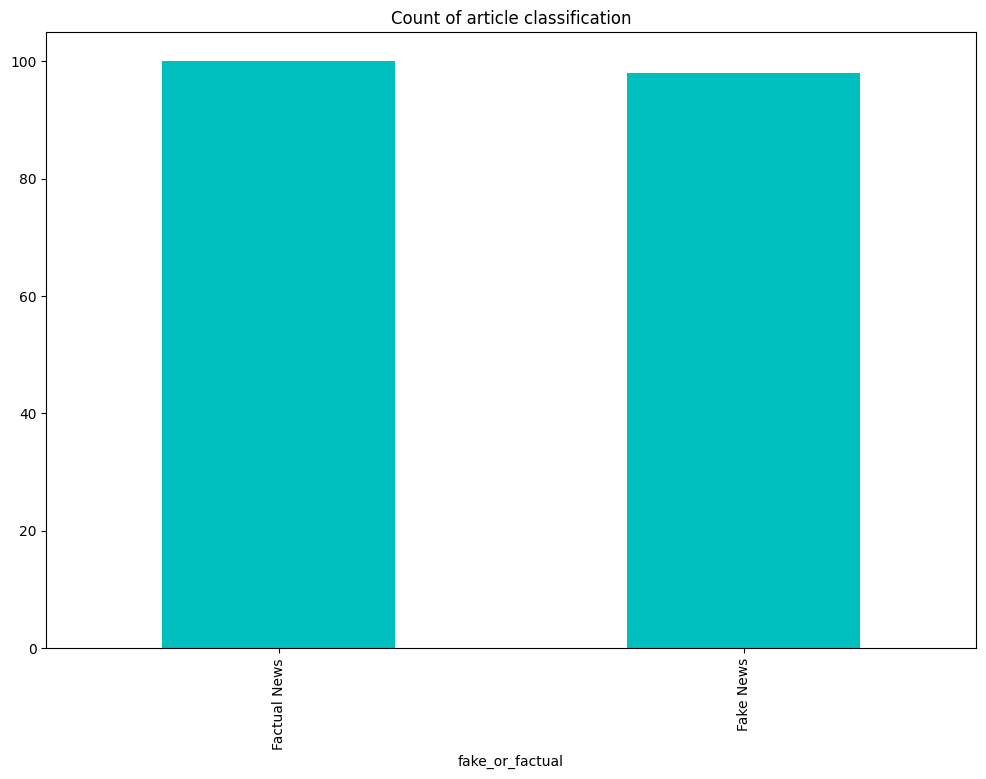

In [6]:
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_color)
plt.title('Count of article classification')

## POS tagging

In [7]:
nlp = spacy.load('en_core_web_sm')

In [8]:
fake_news = data[data['fake_or_factual'] == 'Fake News']
fact_news = data[data['fake_or_factual'] == 'Factual News']

In [9]:
fake_news.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
5,Maxine Waters Makes Teens Chant ‘Impeach 45′ a...,Shame on Teen Vogue! Maxine Waters was a guest...,"Dec 10, 2017",Fake News
6,Jay Carney Let It Slip That He Knows Who Obam...,Former White House Press Secretary in the Obam...,"February 10, 2016",Fake News


In [10]:
fake_spacy_doc = list(nlp.pipe(fake_news['text']))
fact_spacy_doc = list(nlp.pipe(fact_news['text']))

In [11]:
def extract_token_tags(doc: spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [12]:
fake_tags_df = []
columns = ['token', 'ner_tag', 'pos_tag']

In [13]:
for ix, doc in enumerate(fake_spacy_doc):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tags_df.append(tags)

In [14]:
fake_tags_df = pd.concat(fake_tags_df)

In [15]:
fake_tags_df.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [16]:
fact_tags_df = []
columns = ['token', 'ner_tag', 'pos_tag']
for ix, doc in enumerate(fact_spacy_doc):
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tags_df.append(tags)
fact_tags_df = pd.concat(fact_tags_df)

In [17]:
fact_tags_df.head()

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT


In [18]:
pos_count_fake = fake_tags_df.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_count_fake.head()

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875


In [19]:
pos_count_fact = fact_tags_df.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_count_fact.head()

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789


In [20]:
fake_tags_df.groupby(['pos_tag'])['token'].count().sort_values(ascending=False)

pos_tag
NOUN     7799
PROPN    5337
VERB     5281
ADP      4533
PUNCT    4301
DET      3560
PRON     3119
ADJ      2710
AUX      2155
ADV      1672
PART     1312
CCONJ    1176
SPACE     954
SCONJ     950
NUM       690
SYM        90
INTJ       66
X          39
Name: token, dtype: int64

In [21]:
fact_tags_df.groupby(['pos_tag'])['token'].count().sort_values(ascending=False)

pos_tag
NOUN     7288
PROPN    5187
VERB     4516
PUNCT    4436
ADP      4353
DET      3463
ADJ      2540
AUX      1838
PRON     1804
PART     1219
CCONJ     938
ADV       903
SCONJ     680
NUM       672
SPACE     469
SYM        56
X          19
INTJ       12
Name: token, dtype: int64

In [22]:
pos_count_fake[pos_count_fake['pos_tag'] == 'NOUN'][:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [23]:
pos_count_fact[pos_count_fact['pos_tag'] == 'NOUN'][:15]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


## Named Entities

In [24]:
top_entities_fake = fake_tags_df[fake_tags_df['ner_tag'] != ""]\
    .groupby(['token', 'ner_tag']).size()\
    .reset_index(name='counts').sort_values(by='counts', ascending=False)

In [25]:
top_entities_fact = fact_tags_df[fact_tags_df['ner_tag'] != ""]\
    .groupby(['token', 'ner_tag']).size()\
    .reset_index(name='counts').sort_values(by='counts', ascending=False)

In [26]:
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'Most common entities in fake news')]

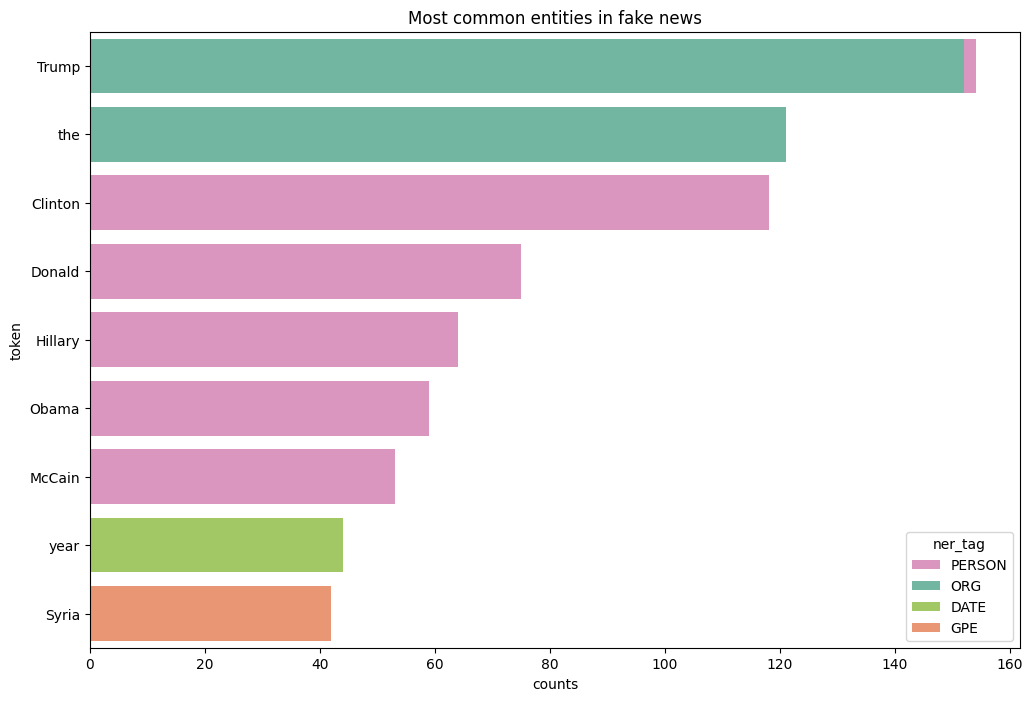

In [27]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[:10],
    orient = 'h',
    dodge = False
).set(title="Most common entities in fake news")

[Text(0.5, 1.0, 'Most common entities in factual news')]

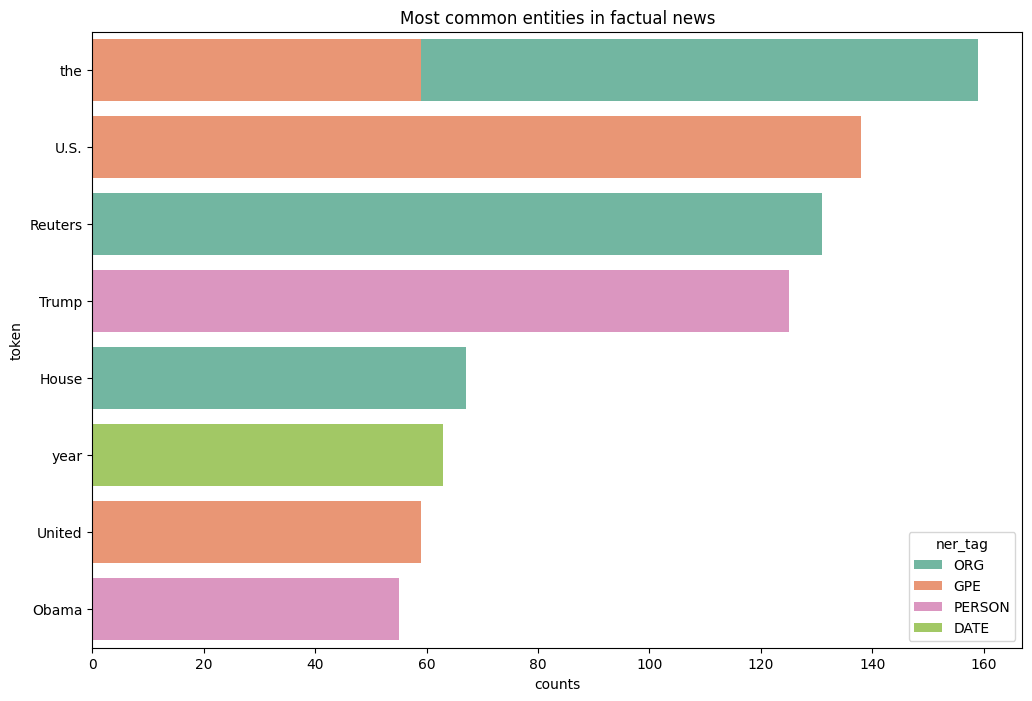

In [28]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[:10],
    orient = 'h',
    dodge = False
).set(title="Most common entities in factual news")

## Text Pre Processing

In [29]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [30]:
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s", "", x['text']), axis=1)

In [31]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,There are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,Buried in Trump s bonkers interview with New Y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"Women make up over 50 percent of this country,..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,U.S. Defense Secretary Jim Mattis said on Mond...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,Northern Ireland s political parties are rapid...


In [32]:
data['text_clean'] = data['text_clean'].str.lower()
data['text_clean'] = data.apply(lambda x: re.sub(r"[^\s\w]", "", x['text_clean']), axis=1)

In [33]:
en_stopwords = stopwords.words('english')

In [34]:
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join(word for word in x.split(" ") if word not in en_stopwords))

In [35]:
data['text_clean'] = data.apply(lambda x: word_tokenize(x['text_clean']), axis=1)

In [36]:
lemmatizer = WordNetLemmatizer()
data['text_clean'] = data['text_clean'].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [37]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [38]:
token_clean = sum(data['text_clean'], [])

In [39]:
print(token_clean[:5])

['two', 'small', 'problem', 'analogy', 'susan']


In [40]:
unigrams = (pd.Series(nltk.ngrams(token_clean, 1)).value_counts().reset_index())
print(unigrams[:10])

           index  count
0       (trump,)    580
1        (said,)    580
2           (u,)    277
3       (state,)    275
4   (president,)    259
5       (would,)    226
6         (one,)    160
7     (clinton,)    141
8        (year,)    139
9  (republican,)    137


In [41]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0])

C:\Users\Aniket\AppData\Local\Temp\ipykernel_19596\2846886226.py:1: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


TypeError: 'Text' object is not callable

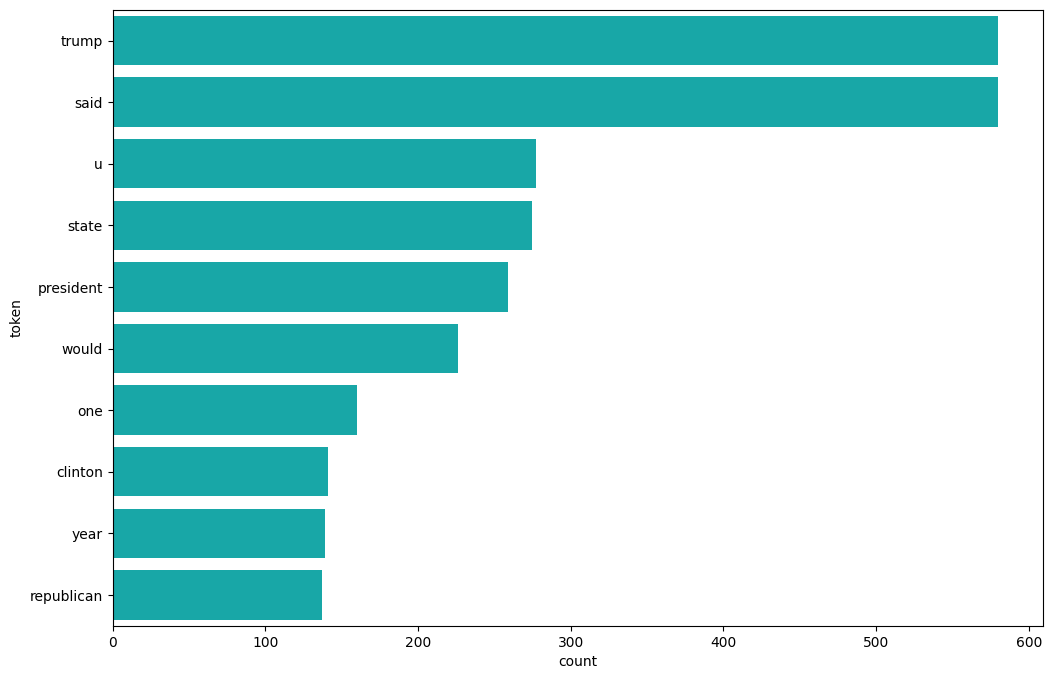

In [42]:
sns.barplot(
    x = "count",
    y = "token",
    data = unigrams[:10],
    orient = "h",
    palette = [default_plot_color],
    hue = "token", legend=False
).title("Most Common Unigrams After Pre Processing")

In [43]:
bigrams = (pd.Series(nltk.ngrams(token_clean, 2)).value_counts().reset_index())[:10]
print(bigrams)

                     index  count
0          (donald, trump)    113
1          (united, state)     84
2           (white, house)     74
3      (president, donald)     47
4       (hillary, clinton)     39
5              (new, york)     33
6         (supreme, court)     30
7             (image, via)     29
8         (official, said)     26
9  (trump, administration)     26


## Sentiment Analysis

In [44]:
vader_sentiment = SentimentIntensityAnalyzer()

In [45]:
data['vader_sentiment_score'] = data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])

In [46]:
 data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [47]:
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

In [48]:
data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels = names)

In [49]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


<Axes: xlabel='vader_sentiment_label'>

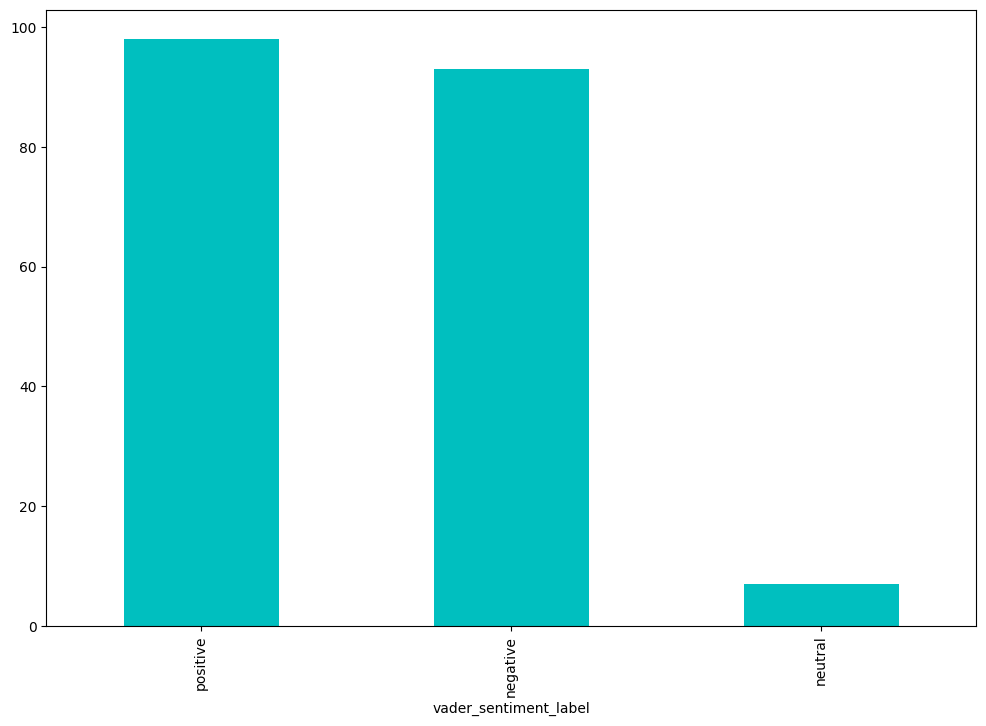

In [50]:
data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_color)

C:\Users\Aniket\AppData\Local\Temp\ipykernel_19596\1250231441.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


TypeError: 'Text' object is not callable

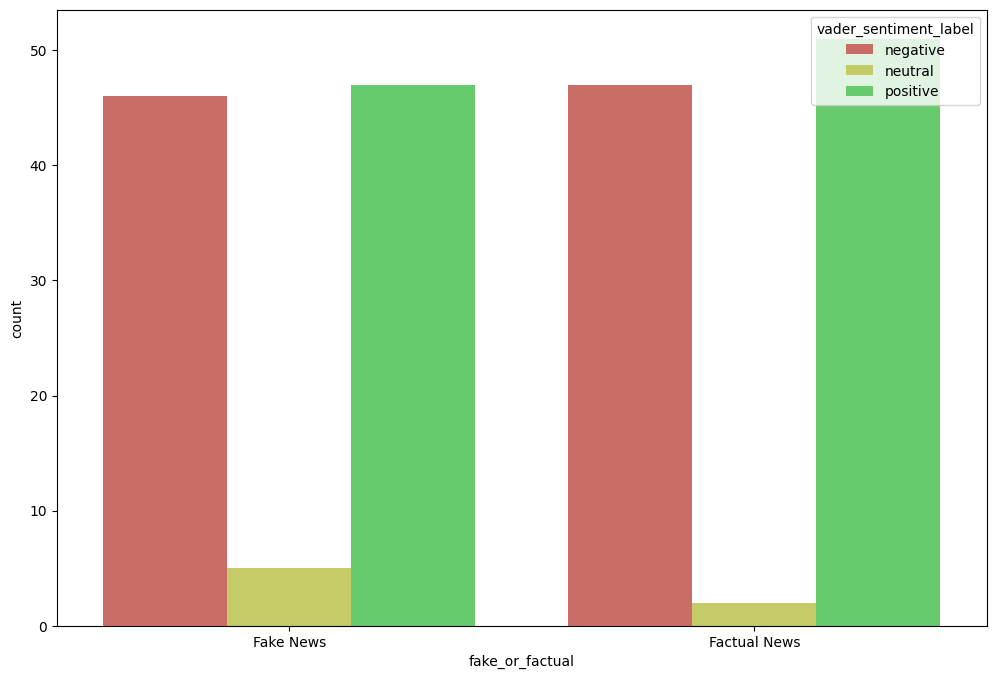

In [51]:
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette = sns.color_palette('hls'),
    data = data
).title('Sentiment By News Type')

## Topic Modelling 

In [52]:
fake_news_text = data[data['fake_or_factual'] == "Fake News"]["text_clean"].reset_index(drop=True)

In [53]:
dictionary_fake = corpora.Dictionary(fake_news_text)

In [54]:
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

In [56]:
coherence_values = []
model_list = []
min_topics = 2
max_topics = 11
for num_topics_i in range(min_topics, max_topics + 1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics = num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

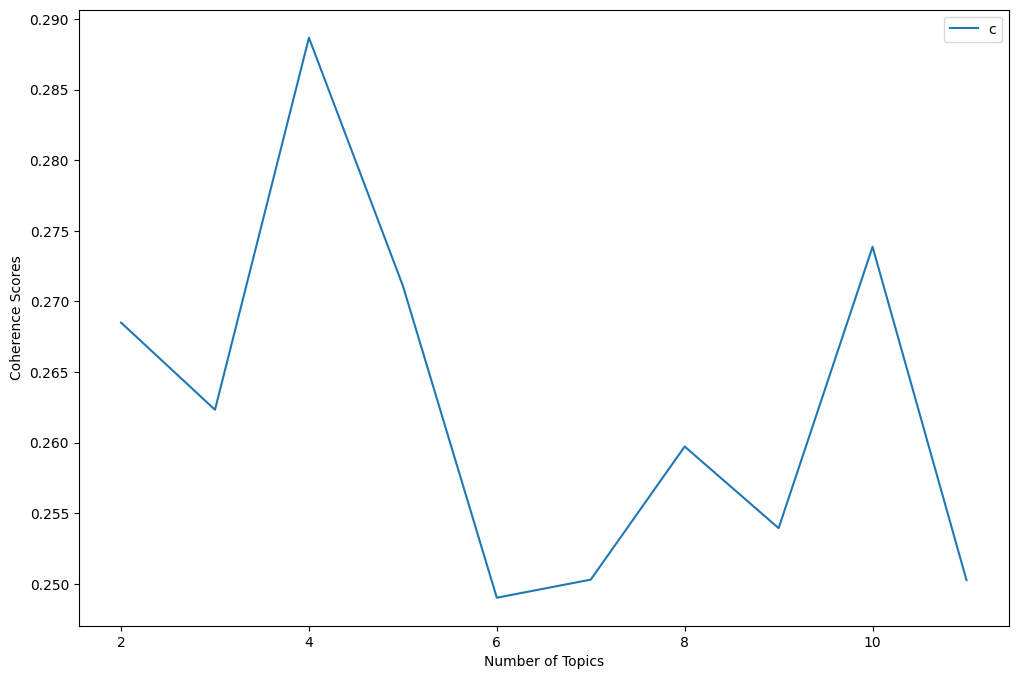

In [57]:
plt.plot(range(min_topics, max_topics + 1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Scores")
plt.legend(("coherence_values"), loc="best")
plt.show()

In [59]:
num_topics_lda = 4
lda_model = gensim.models.LdaModel(corpus=doc_term_fake, id2word=dictionary_fake, num_topics = num_topics_lda )

In [60]:
lda_model.print_topics(num_topics = num_topics_lda, num_words = 10)

[(0,
  '0.007*"trump" + 0.005*"said" + 0.004*"president" + 0.004*"republican" + 0.004*"state" + 0.004*"one" + 0.004*"clinton" + 0.003*"hillary" + 0.003*"u" + 0.003*"like"'),
 (1,
  '0.008*"trump" + 0.005*"president" + 0.005*"would" + 0.004*"said" + 0.004*"one" + 0.003*"state" + 0.003*"donald" + 0.003*"u" + 0.003*"go" + 0.003*"time"'),
 (2,
  '0.012*"trump" + 0.005*"state" + 0.005*"said" + 0.005*"president" + 0.005*"clinton" + 0.004*"would" + 0.004*"time" + 0.003*"people" + 0.003*"woman" + 0.003*"one"'),
 (3,
  '0.015*"trump" + 0.005*"u" + 0.005*"clinton" + 0.004*"said" + 0.004*"president" + 0.003*"donald" + 0.003*"woman" + 0.003*"obama" + 0.003*"one" + 0.003*"people"')]

In [61]:
def tfidf_corpus(doc_term_matrix):
    tfidf = TfidfModel(corpus = doc_term_matrix, normalize = True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [73]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics + 1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word=dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel('Number Of Topics')
    plt.ylabel('Coherence Score')
    plt.legend(('coherence_values'), loc='best')
    plt.show()

In [74]:
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)

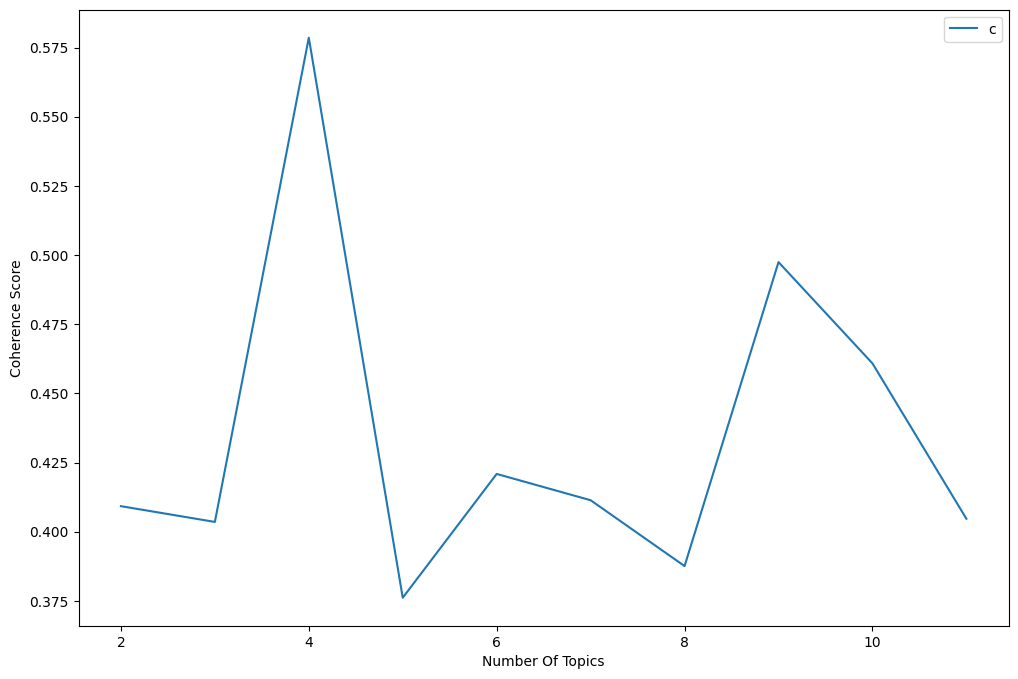

In [75]:
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [76]:
lsa_model = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics = 4)

In [77]:
lsa_model.print_topics()

[(0,
  '0.190*"trump" + 0.136*"clinton" + 0.095*"hillary" + 0.094*"obama" + 0.089*"president" + 0.087*"woman" + 0.078*"republican" + 0.077*"party" + 0.077*"flynn" + 0.074*"candidate"'),
 (1,
  '-0.325*"boiler" + -0.284*"acr" + -0.244*"room" + -0.240*"pm" + -0.186*"broadcast" + -0.180*"radio" + -0.142*"tune" + -0.142*"animal" + -0.134*"jay" + -0.132*"episode"'),
 (2,
  '-0.623*"flynn" + -0.182*"immunity" + -0.122*"nana" + -0.116*"mr" + -0.110*"30" + -0.108*"march" + -0.102*"russian" + -0.100*"source" + 0.095*"school" + -0.092*"adviser"'),
 (3,
  '0.217*"clinton" + -0.186*"school" + -0.176*"student" + 0.141*"hillary" + -0.121*"county" + -0.121*"flynn" + 0.110*"sander" + 0.098*"debate" + 0.097*"woman" + 0.091*"nominee"')]

## Creating cutom classifier

In [81]:
X = [','.join(map(str, l)) for l in data['text_clean']]

In [85]:
Y = data['fake_or_factual']

In [86]:
countvectorizer = CountVectorizer()

In [87]:
countvec_fit = countvectorizer.fit_transform(X)

In [91]:
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns=countvectorizer.get_feature_names_out())

In [95]:
x_train, x_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)

In [96]:
lr = LogisticRegression(random_state=0).fit(x_train, y_train)

In [97]:
 y_pred_lr = lr.predict(x_test)

In [98]:
accuracy_score(y_pred_lr, y_test)

0.9166666666666666

In [99]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.89      0.93      0.91        27
   Fake News       0.94      0.91      0.92        33

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



In [100]:
svm = SGDClassifier().fit(x_train, y_train)

In [101]:
y_pred_svm = svm.predict(x_test)

In [102]:
accuracy_score(y_pred_svm, y_test)

0.8333333333333334

In [104]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.81      0.81      0.81        27
   Fake News       0.85      0.85      0.85        33

    accuracy                           0.83        60
   macro avg       0.83      0.83      0.83        60
weighted avg       0.83      0.83      0.83        60

